# **Red neuronal convolucional para el diagnóstico de nódulos tiroideos según la clasificación EU-TIRADS**

## Por Alejandro Martínez Hernández

### Notebook 3/3

# **Creación de modelos**

PAra la siguiente parte se crearan los siguientes modelos de clasificación simple:
- SVM con crossvalidation y gridsearch para buscar parámetros.
- SVM con preprocesamiento de datos con PCA, crossvalidation y gridsearch para buscar parámetros.
- Forest con crossvalidation y gridsearch para buscar parámetros.
- Forest con preprocesamiento de datos con PCA, crossvalidation y gridsearch para buscar parámetros.

## **SVM**

### **Crossvalidation + GridSearch**


In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# Ruta relativa a la carpeta que contiene las imágenes organizadas por etiquetas
data_dir = "db_unal/organized/images/cropped"
categories = ['high', 'low']

# Listas para almacenar los datos de las imágenes y sus etiquetas
data = []
labels = []

# Cargar las imágenes y las etiquetas desde las carpetas
for category in categories:
    path = os.path.join(data_dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = cv2.imread(img_path)
        if image is not None:
            # Convertir imagen a escala de grises y redimensionar
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (128, 128))
            # Aplanar la imagen para crear un vector de características
            flattened_image = image.flatten()
            data.append(flattened_image)
            labels.append(category)

# Convertir las listas de datos y etiquetas en arrays de numpy
data = np.array(data)
labels = np.array(labels)

# Parámetros para GridSearch
param_grid = {
    'C': [0.1, 1, 10],  # valores de C
    'gamma': ['scale', 'auto', 0.1, 0.001],  # valores de gamma
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']  # tipos de kernel
}

# Crear el modelo SVM
svm_model = svm.SVC()

# Configuración de GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, verbose=1, scoring='accuracy')

# Ejecutar GridSearch
grid_search.fit(data, labels)

# Mejor modelo y parámetros
print("Mejor modelo:", grid_search.best_estimator_)
print("Mejor conjunto de parámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejor modelo: SVC(C=10)
Mejor conjunto de parámetros: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Mejor puntuación de validación cruzada: 0.7071808510638297


### **PCA + Crossvalidation + GridSearch**

En este código, se han modificado varias partes del anterior para incluir PCA:

- **Pipeline de sklearn:** Utiliza Pipeline para encadenar PCA y SVM. Esto garantiza que PCA se aplique a los datos antes de que se pase a SVM en cada iteración del proceso de entrenamiento y validación cruzada.

- **Parámetros de GridSearch:** Se actualizó param_grid para ajustarlo al pipeline, especificando que los parámetros se apliquen al estimador SVM dentro del pipeline (notado por el prefijo 'svm__' en los nombres de los parámetros).

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Ruta relativa a la carpeta que contiene las imágenes organizadas por etiquetas
data_dir = "db_unal/organized/images/cropped"
categories = ['high', 'low']

# Listas para almacenar los datos de las imágenes y sus etiquetas
data = []
labels = []

# Cargar las imágenes y las etiquetas desde las carpetas
for category in categories:
    path = os.path.join(data_dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = cv2.imread(img_path)
        if image is not None:
            # Convertir imagen a escala de grises y redimensionar
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (128, 128))
            # Aplanar la imagen para crear un vector de características
            flattened_image = image.flatten()
            data.append(flattened_image)
            labels.append(category)

# Convertir las listas de datos y etiquetas en arrays de numpy
data = np.array(data)
labels = np.array(labels)

# Definir el número de componentes para PCA
n_components = 100  # Este valor puede ser ajustado según la varianza a conservar

# Crear un pipeline que incluya PCA y SVM
pipeline = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('svm', svm.SVC())
])

# Parámetros para GridSearch
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 'auto', 0.1, 0.001],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Configuración de GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='accuracy')

# Ejecutar GridSearch
grid_search.fit(data, labels)

# Mejor modelo y parámetros
print("Mejor modelo:", grid_search.best_estimator_)
print("Mejor conjunto de parámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejor modelo: Pipeline(steps=[('pca', PCA(n_components=100)), ('svm', SVC(C=1))])
Mejor conjunto de parámetros: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Mejor puntuación de validación cruzada: 0.6822695035460993


## **Random Forest**

### **Crossvalidation + GridSearch**

In [3]:
import os
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Ruta relativa a la carpeta que contiene las imágenes organizadas por etiquetas
data_dir = "db_unal/organized/images/cropped"
categories = ['high', 'low']

# Listas para almacenar los datos de las imágenes y sus etiquetas
data = []
labels = []

# Cargar las imágenes y las etiquetas desde las carpetas
for category in categories:
    path = os.path.join(data_dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = cv2.imread(img_path)
        if image is not None:
            # Convertir imagen a escala de grises y redimensionar
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (128, 128))
            # Aplanar la imagen para crear un vector de características
            flattened_image = image.flatten()
            data.append(flattened_image)
            labels.append(category)

# Convertir las listas de datos y etiquetas en arrays de numpy
data = np.array(data)
labels = np.array(labels)

# Parámetros para GridSearch
param_grid = {
    'n_estimators': [10, 100],  # Número de árboles en el bosque
    'max_features': ['auto', 'sqrt', 'log2'],  # Número de características a considerar al buscar la mejor división
    'max_depth': [None, 10, 20],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5],  # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2],  # Número mínimo de muestras requeridas en cada hoja del árbol
    'bootstrap': [True, False]  # Método para muestrear puntos de datos (con o sin reemplazo)
}

# Crear el modelo de Random Forest
forest_model = RandomForestClassifier()

# Configuración de GridSearchCV
grid_search = GridSearchCV(forest_model, param_grid, cv=5, verbose=1, scoring='accuracy')

# Ejecutar GridSearch
grid_search.fit(data, labels)

# Mejor modelo y parámetros
print("Mejor modelo:", grid_search.best_estimator_)
print("Mejor conjunto de parámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
240 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\sklearn\base.py", line 6

Mejor modelo: RandomForestClassifier(bootstrap=False, min_samples_split=5, n_estimators=10)
Mejor conjunto de parámetros: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
Mejor puntuación de validación cruzada: 0.702659574468085


### **PCA + Crossvalidation + GridSearch**

In [4]:
import os
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Ruta relativa a la carpeta que contiene las imágenes organizadas por etiquetas
data_dir = "db_unal/organized/images/cropped"
categories = ['high', 'low']

# Listas para almacenar los datos de las imágenes y sus etiquetas
data = []
labels = []

# Cargar las imágenes y las etiquetas desde las carpetas
for category in categories:
    path = os.path.join(data_dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = cv2.imread(img_path)
        if image is not None:
            # Convertir imagen a escala de grises y redimensionar
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (128, 128))
            # Aplanar la imagen para crear un vector de características
            flattened_image = image.flatten()
            data.append(flattened_image)
            labels.append(category)

# Convertir las listas de datos y etiquetas en arrays de numpy
data = np.array(data)
labels = np.array(labels)

# Definir el número de componentes principales para PCA
n_components = 100

# Crear un pipeline que incluya PCA y Random Forest
pipeline = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('forest', RandomForestClassifier())
])

# Parámetros para GridSearch
param_grid = {
    'forest__n_estimators': [10, 100],
    'forest__max_features': ['auto', 'sqrt', 'log2'],
    'forest__max_depth': [None, 10, 20],
    'forest__min_samples_split': [2, 5],
    'forest__min_samples_leaf': [1, 2],
    'forest__bootstrap': [True, False]
}

# Configuración de GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='accuracy')

# Ejecutar GridSearch
grid_search.fit(data, labels)

# Mejor modelo y parámetros
print("Mejor modelo:", grid_search.best_estimator_)
print("Mejor conjunto de parámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
240 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\alema\Desktop\pape

Mejor modelo: Pipeline(steps=[('pca', PCA(n_components=100)),
                ('forest',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='log2', min_samples_leaf=2,
                                        min_samples_split=5))])
Mejor conjunto de parámetros: {'forest__bootstrap': False, 'forest__max_depth': 10, 'forest__max_features': 'log2', 'forest__min_samples_leaf': 2, 'forest__min_samples_split': 5, 'forest__n_estimators': 100}
Mejor puntuación de validación cruzada: 0.7069148936170213


## **Naive Bayes**

### **Crossvalidation + GridSearch**

In [6]:
import os
import cv2
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Ruta relativa a la carpeta que contiene las imágenes organizadas por etiquetas
data_dir = "db_unal/organized/images/cropped"
categories = ['high', 'low']

# Listas para almacenar los datos de las imágenes y sus etiquetas
data = []
labels = []

# Cargar las imágenes y las etiquetas desde las carpetas
for category in categories:
    path = os.path.join(data_dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = cv2.imread(img_path)
        if image is not None:
            # Convertir imagen a escala de grises y redimensionar
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (128, 128))
            # Aplanar la imagen para crear un vector de características
            flattened_image = image.flatten()
            data.append(flattened_image)
            labels.append(category)

# Convertir las listas de datos y etiquetas en arrays de numpy
data = np.array(data)
labels = np.array(labels)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Parámetros para GridSearch
param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

# Crear el modelo de Naive Bayes
nb_model = GaussianNB()

# Configuración de GridSearchCV
grid_search = GridSearchCV(nb_model, param_grid, cv=5, verbose=1, scoring='accuracy')

# Ejecutar GridSearch
grid_search.fit(X_train, y_train)

# Mejor modelo y parámetros
print("Mejor modelo:", grid_search.best_estimator_)
print("Mejor conjunto de parámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

# Realizar predicciones con los datos de prueba
y_pred = grid_search.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mejor modelo: GaussianNB(var_smoothing=0.03511191734215131)
Mejor conjunto de parámetros: {'var_smoothing': 0.03511191734215131}
Mejor puntuación de validación cruzada: 0.6183535762483131
Accuracy: 0.6458333333333334
Classification Report:
               precision    recall  f1-score   support

        high       0.68      0.65      0.67        26
         low       0.61      0.64      0.62        22

    accuracy                           0.65        48
   macro avg       0.64      0.65      0.64        48
weighted avg       0.65      0.65      0.65        48



### **PCA + Crossvalidation + GridSearch**

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mejor modelo: GaussianNB(var_smoothing=0.03511191734215131)
Mejor conjunto de parámetros: {'var_smoothing': 0.03511191734215131}
Mejor puntuación de validación cruzada: 0.6183535762483131
Accuracy: 0.6458333333333334
Classification Report:
               precision    recall  f1-score   support

        high       0.68      0.65      0.67        26
         low       0.61      0.64      0.62        22

    accuracy                           0.65        48
   macro avg       0.64      0.65      0.64        48
weighted avg       0.65      0.65      0.65        48



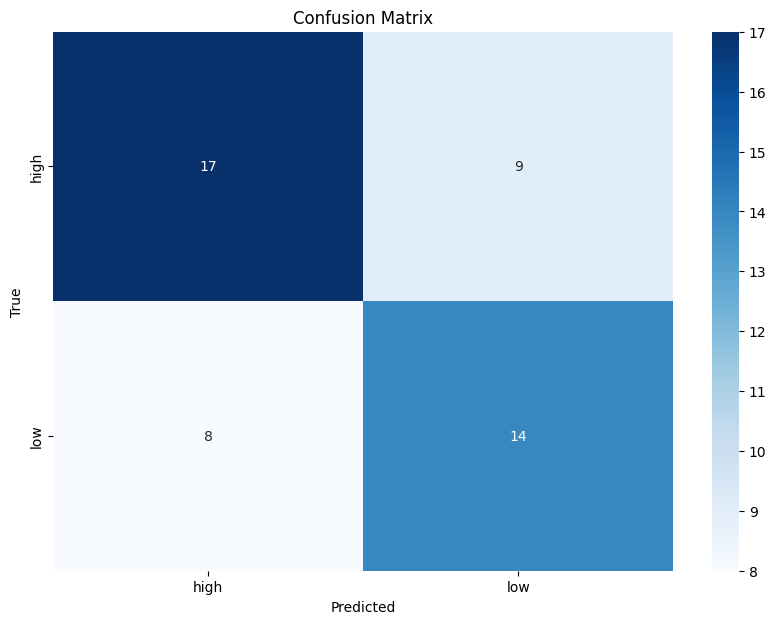

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Ruta relativa a la carpeta que contiene las imágenes organizadas por etiquetas
data_dir = "db_unal/organized/images/cropped"
categories = ['high', 'low']

# Listas para almacenar los datos de las imágenes y sus etiquetas
data = []
labels = []

# Cargar las imágenes y las etiquetas desde las carpetas
for category in categories:
    path = os.path.join(data_dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = cv2.imread(img_path)
        if image is not None:
            # Convertir imagen a escala de grises y redimensionar
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (128, 128))
            # Aplanar la imagen para crear un vector de características
            flattened_image = image.flatten()
            data.append(flattened_image)
            labels.append(category)

# Convertir las listas de datos y etiquetas en arrays de numpy
data = np.array(data)
labels = np.array(labels)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Parámetros para GridSearch
param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

# Crear el modelo de Naive Bayes
nb_model = GaussianNB()

# Configuración de GridSearchCV
grid_search = GridSearchCV(nb_model, param_grid, cv=5, verbose=1, scoring='accuracy')

# Ejecutar GridSearch
grid_search.fit(X_train, y_train)

# Mejor modelo y parámetros
print("Mejor modelo:", grid_search.best_estimator_)
print("Mejor conjunto de parámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

# Realizar predicciones con los datos de prueba
y_pred = grid_search.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
cm_labels = categories

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


t-sne

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mejor modelo: GaussianNB(var_smoothing=0.03511191734215131)
Mejor conjunto de parámetros: {'var_smoothing': 0.03511191734215131}
Mejor puntuación de validación cruzada: 0.6183535762483131
Accuracy: 0.6458333333333334
Classification Report:
               precision    recall  f1-score   support

        high       0.68      0.65      0.67        26
         low       0.61      0.64      0.62        22

    accuracy                           0.65        48
   macro avg       0.64      0.65      0.64        48
weighted avg       0.65      0.65      0.65        48



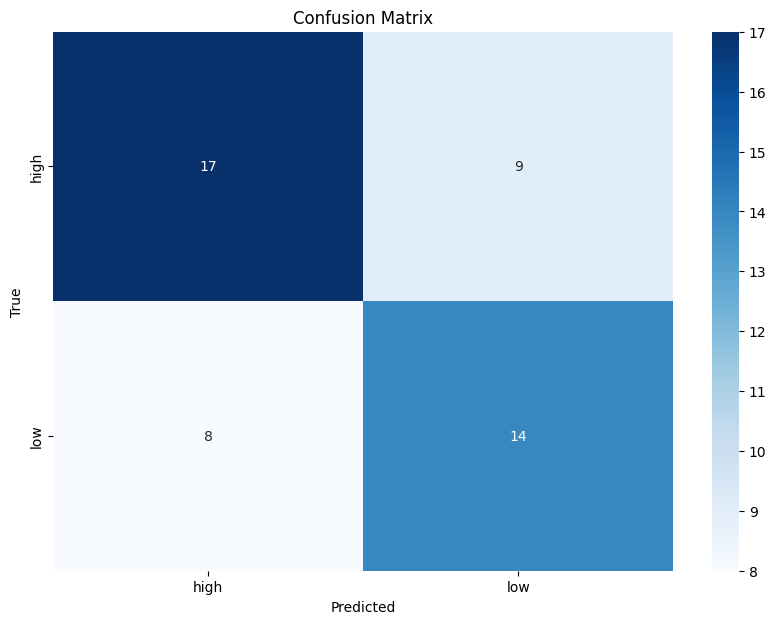

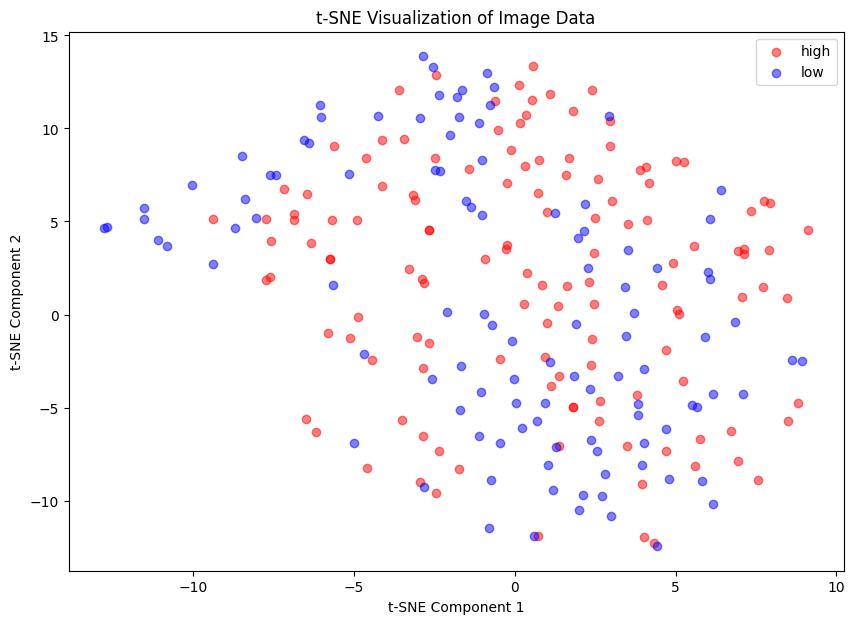

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.manifold import TSNE

# Ruta relativa a la carpeta que contiene las imágenes organizadas por etiquetas
data_dir = "db_unal/organized/images/cropped"
categories = ['high', 'low']

# Listas para almacenar los datos de las imágenes y sus etiquetas
data = []
labels = []

# Cargar las imágenes y las etiquetas desde las carpetas
for category in categories:
    path = os.path.join(data_dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = cv2.imread(img_path)
        if image is not None:
            # Convertir imagen a escala de grises y redimensionar
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (128, 128))
            # Aplanar la imagen para crear un vector de características
            flattened_image = image.flatten()
            data.append(flattened_image)
            labels.append(category)

# Convertir las listas de datos y etiquetas en arrays de numpy
data = np.array(data)
labels = np.array(labels)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Parámetros para GridSearch
param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

# Crear el modelo de Naive Bayes
nb_model = GaussianNB()

# Configuración de GridSearchCV
grid_search = GridSearchCV(nb_model, param_grid, cv=5, verbose=1, scoring='accuracy')

# Ejecutar GridSearch
grid_search.fit(X_train, y_train)

# Mejor modelo y parámetros
print("Mejor modelo:", grid_search.best_estimator_)
print("Mejor conjunto de parámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

# Realizar predicciones con los datos de prueba
y_pred = grid_search.predict(X_test)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
cm_labels = categories

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Reducir la dimensionalidad de los datos para visualización con t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(data)

# Asignar colores a cada categoría
colors = {'high': 'red', 'low': 'blue'}

# Visualizar los datos en el espacio t-SNE
plt.figure(figsize=(10, 7))
for label in categories:
    indices = np.where(labels == label)
    plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], c=colors[label], label=label, alpha=0.5)
plt.legend()
plt.title('t-SNE Visualization of Image Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
